In [ ]:
import pandas as pd
from config import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


def preprocess_and_split_datasets_stratified(datasets, ignored_features, target_names):
    """
    Preprocesses each dataset by encoding, handling missing values,
    removing ignored features, and splitting into train and test sets with stratification.

    Args:
    datasets (dict): Dictionary of datasets.
    ignored_features (dict): Dictionary of features to ignore for each dataset.
    target_names (dict): Dictionary of target variable names for each dataset.

    Yields:
    tuple: For each dataset, yields (X_train, y_train, X_test, y_test, dataset_name).
    """
    for dataset_name, dataset in datasets.items():
        # Removing ignored features
        features_to_use = [
            feat
            for feat in dataset.columns
            if feat not in ignored_features[dataset_name]
        ]
        data_processed = dataset[features_to_use]

        # Encoding categorical features
        le = LabelEncoder()
        data_processed = data_processed.apply(
            lambda col: le.fit_transform(col) if col.dtype == "object" else col
        )

        # Filing missing values with the median
        data_processed = data_processed.fillna(data_processed.median())

        # Splitting into features and target
        X = data_processed.drop(target_names[dataset_name], axis=1)
        y = data_processed[target_names[dataset_name]]

        # Scaling the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, stratify=y, random_state=42
        )

        yield X_train, y_train, X_test, y_test, dataset_name


# Load the datasets
datasets = {
    # DATA_2_NAME: pd.read_csv(DATA_2_PATH),
    DATA_4_NAME: pd.read_csv(DATA_4_PATH),
    DATA_5_NAME: pd.read_csv(DATA_5_PATH),
    DATA_6_NAME: pd.read_csv(DATA_6_PATH),
    DATA_7_NAME: pd.read_csv(DATA_7_PATH),
    DATA_8_NAME: pd.read_csv(DATA_8_PATH),
}
# Ignored features for each dataset
ignored_features = {
    # DATA_2_NAME: DATA_2_IGNORED_FEAT,
    DATA_4_NAME: DATA_4_IGNORED_FEAT,
    DATA_5_NAME: DATA_5_IGNORED_FEAT,
    DATA_6_NAME: DATA_6_IGNORED_FEAT,
    DATA_7_NAME: DATA_7_IGNORED_FEAT,
    DATA_8_NAME: DATA_8_IGNORED_FEAT,
}
# Target variable names for each dataset
target_names = {
    # DATA_2_NAME: DATA_2_TARGET,
    DATA_4_NAME: DATA_4_TARGET,
    DATA_5_NAME: DATA_5_TARGET,
    DATA_6_NAME: DATA_6_TARGET,
    DATA_7_NAME: DATA_7_TARGET,
    DATA_8_NAME: DATA_8_TARGET,
}


dataset_splits_stratified = list(
    preprocess_and_split_datasets_stratified(datasets, ignored_features, target_names)
)

# Displaying the shapes of the splits for each dataset as a check
split_shapes_stratified = {
    name: (split[0].shape, split[1].shape, split[2].shape, split[3].shape)
    for name, split in zip(datasets.keys(), dataset_splits_stratified)
}
split_shapes_stratified

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from adapt.instance_based import TrAdaBoost


def initialize_models(Xt, yt):
    """
    Initializes a list of machine learning models for classification, including a TrAdaBoost with RidgeClassifier.

    Parameters:
    Xt: DataFrame
        Features from the source domain.
    yt: Series or DataFrame
        Labels from the source domain.

    Returns:
    A list of model instances.
    """
    models = []

    # ID3 - Decision Tree with entropy criterion
    models.append(DecisionTreeClassifier(criterion="entropy", random_state=42))

    # Logistic Regression
    models.append(LogisticRegression(random_state=42))

    # Random Forest
    models.append(RandomForestClassifier(random_state=42))

    # KNN
    models.append(KNeighborsClassifier())

    # SVM
    models.append(SVC(probability=True, random_state=42))

    # Naive Bayes
    models.append(GaussianNB())

    # Simple ANN
    models.append(MLPClassifier(tol=1e-4, max_iter=1000, random_state=42))

    # TrAdaBoost with RidgeClassifier
    ridge_classifier = RidgeClassifier()
    trada_boost_ridge = TrAdaBoost(
        estimator=ridge_classifier, n_estimators=10, Xt=Xt, yt=yt, random_state=42
    )
    models.append(trada_boost_ridge)

    return models

In [ ]:
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import numpy as np

def remove_outliers_none(X, y):
    return X, y

def remove_outliers_isolation_forest(X, y):
    # Example implementation, you can adjust parameters
    iso_forest = IsolationForest(contamination=0.1)
    outliers = iso_forest.fit_predict(X)
    return X[outliers == 1], y[outliers == 1]

def remove_outliers_zscore(X, y):
    z_scores = np.abs(stats.zscore(X))
    filtered_entries = (z_scores < 3).all(axis=1)
    return X[filtered_entries], y[filtered_entries]

def remove_outliers_iqr(X, y):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    filtered_entries = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[filtered_entries], y[filtered_entries]

def remove_outliers_dbscan(X, y):
    # Example implementation, you can adjust parameters
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(X)
    return X[clusters != -1], y[clusters != -1]

def remove_outliers_lof(X, y):
    # Example implementation, you can adjust parameters
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outliers = lof.fit_predict(X)
    return X[outliers == 1], y[outliers == 1]


In [ ]:
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, RFE, VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

def features_selection_none(X_train, y_train, X_test):
    return X_train, X_test

def features_selection_extratrees(X_train, y_train, X_test):
    model = ExtraTreesClassifier()
    model.fit(X_train, y_train)
    selector = SelectFromModel(model, prefit=True)
    return selector.transform(X_train), selector.transform(X_test)

def features_selection_mutual_information(X_train, y_train, X_test):
    mi = mutual_info_classif(X_train, y_train)
    mi_threshold = np.mean(mi)  # You can choose a different threshold
    high_mi = mi > mi_threshold
    return X_train[:, high_mi], X_test[:, high_mi]

def features_selection_rfe(X_train, y_train, X_test):
    estimator = RandomForestClassifier()
    selector = RFE(estimator, n_features_to_select=5, step=1)  # Adjust the number of features
    selector = selector.fit(X_train, y_train)
    return selector.transform(X_train), selector.transform(X_test)

def features_selection_variance_threshold(X_train, y_train, X_test):
    selector = VarianceThreshold(threshold=(.8 * (1 - .8)))  # Adjust the threshold
    selector.fit(X_train)
    return selector.transform(X_train), selector.transform(X_test)


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE


def oversampling_none(X, y):
    return X, y


def oversampling_smote(X, y):
    smote = SMOTE()
    return smote.fit_resample(X, y)


def oversampling_adasyn(X, y):
    adasyn = ADASYN()
    return adasyn.fit_resample(X, y)


def oversampling_smote_borderline(X, y):
    smote_borderline = BorderlineSMOTE()
    return smote_borderline.fit_resample(X, y)


def oversampling_nc_smote(X, y):
    nc_smote = SMOTE()
    return nc_smote.fit_resample(X, y)

In [ ]:
import itertools


def generate_configurations():
    remove_outliers_methods = [
        # remove_outliers_none,
        remove_outliers_isolation_forest,
        remove_outliers_zscore,
        remove_outliers_iqr,
        remove_outliers_dbscan,
        remove_outliers_lof,
    ]

    feature_selection_methods = [
        # features_selection_none,
        features_selection_extratrees,
        features_selection_mutual_information,
        features_selection_rfe,
        features_selection_variance_threshold,
    ]

    oversampling_methods = [
        # oversampling_none,
        oversampling_smote,
        # oversampling_svm_smote,
        oversampling_adasyn,
        oversampling_smote_borderline,
        oversampling_nc_smote,
    ]

    for config in itertools.product(
        remove_outliers_methods, feature_selection_methods, oversampling_methods
    ):
        yield config


def apply_configuration(X_train, y_train, X_test, y_test, config):
    remove_outliers_method, feature_selection_method, oversampling_method = config

    # Apply Outlier Removal
    X_train, y_train = remove_outliers_method(X_train, y_train)
    X_test, y_test = remove_outliers_method(
        X_test, y_test
    )  # Assuming the same method applies to test set

    # Apply Feature Selection
    X_train, X_test = feature_selection_method(X_train, y_train, X_test)

    # Apply Oversampling
    X_train, y_train = oversampling_method(X_train, y_train)

    return X_train, y_train, X_test, y_test

# Baseline

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import warnings
import json

warnings.simplefilter(action="ignore", category=FutureWarning)

results_baseline = []
for X_train, y_train, X_test, y_test, dataset_name in dataset_splits_stratified:
    for model in initialize_models(Xt=X_train, yt=y_train):
        model_name = type(model).__name__
        print(f"Training {model_name} on {dataset_name}...")

        # Training the model
        model.fit(X_train, y_train)

        # Making predictions
        y_pred = model.predict(X_test)
        y_proba = (
            model.predict_proba(X_test)[:, 1]
            if hasattr(model, "predict_proba")
            else None
        )

        # Calculating metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="binary", zero_division=0)
        recall = recall_score(y_test, y_pred, average="binary")
        f1 = f1_score(y_test, y_pred, average="binary")
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        # Storing the results
        results_baseline.append(
            {
                "Dataset": dataset_name,
                "Model": model_name,
                "Configuration": "Baseline",
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "ROC-AUC": roc_auc,
            }
        )

# Displaying results
for result in results_baseline:
    print(result)

results_json = json.dumps(results_baseline, indent=4)
with open('results_baseline.json', 'w') as file:
    file.write(results_json)

# Other Configurations

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import warnings
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

results = []

print(len(list(generate_configurations())))
total_iter = (
    len(list(generate_configurations()))
    * len(dataset_splits_stratified)
    * len(list(initialize_models(Xt=None, yt=None)))
)
pbar = tqdm(total=total_iter)
for config in generate_configurations():
    config_name = f"{config[0].__name__}/{config[1].__name__}/{config[2].__name__}"
    for X_train, y_train, X_test, y_test, dataset_name in dataset_splits_stratified:
        for model in initialize_models(Xt=X_train, yt=y_train):
            model_name = type(model).__name__
            pbar.update(1)
            # print(
            #     f"Training {model_name} on {dataset_name} with configuration {config_name}..."
            # )
            try:
                X_train, y_train, X_test, y_test = apply_configuration(
                    X_train, y_train, X_test, y_test, config
                )
                # Training the model
                model.fit(X_train, y_train)

                # Making predictions
                y_pred = model.predict(X_test)
                y_proba = (
                    model.predict_proba(X_test)[:, 1]
                    if hasattr(model, "predict_proba")
                    else None
                )

                # Calculating metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(
                    y_test, y_pred, average="binary", zero_division=0
                )
                recall = recall_score(y_test, y_pred, average="binary")
                f1 = f1_score(y_test, y_pred, average="binary")
                roc_auc = (
                    roc_auc_score(y_test, y_proba) if y_proba is not None else None
                )

                # Storing the results
                results.append(
                    {
                        "Dataset": dataset_name,
                        "Configuration": config_name,
                        "Model": model_name,
                        "Accuracy": accuracy,
                        "Precision": precision,
                        "Recall": recall,
                        "F1-Score": f1,
                        "ROC-AUC": roc_auc,
                    }
                )
            except Exception as e:
                print(
                    f"An exception occurred for {model_name} on {dataset_name} with configuration {config_name}: {e}"
                )

pbar.close()
# Displaying results
for result in results:
    print(result)
results_json = json.dumps(results, indent=4)
with open("results.json", "w") as file:
    file.write(results_json)

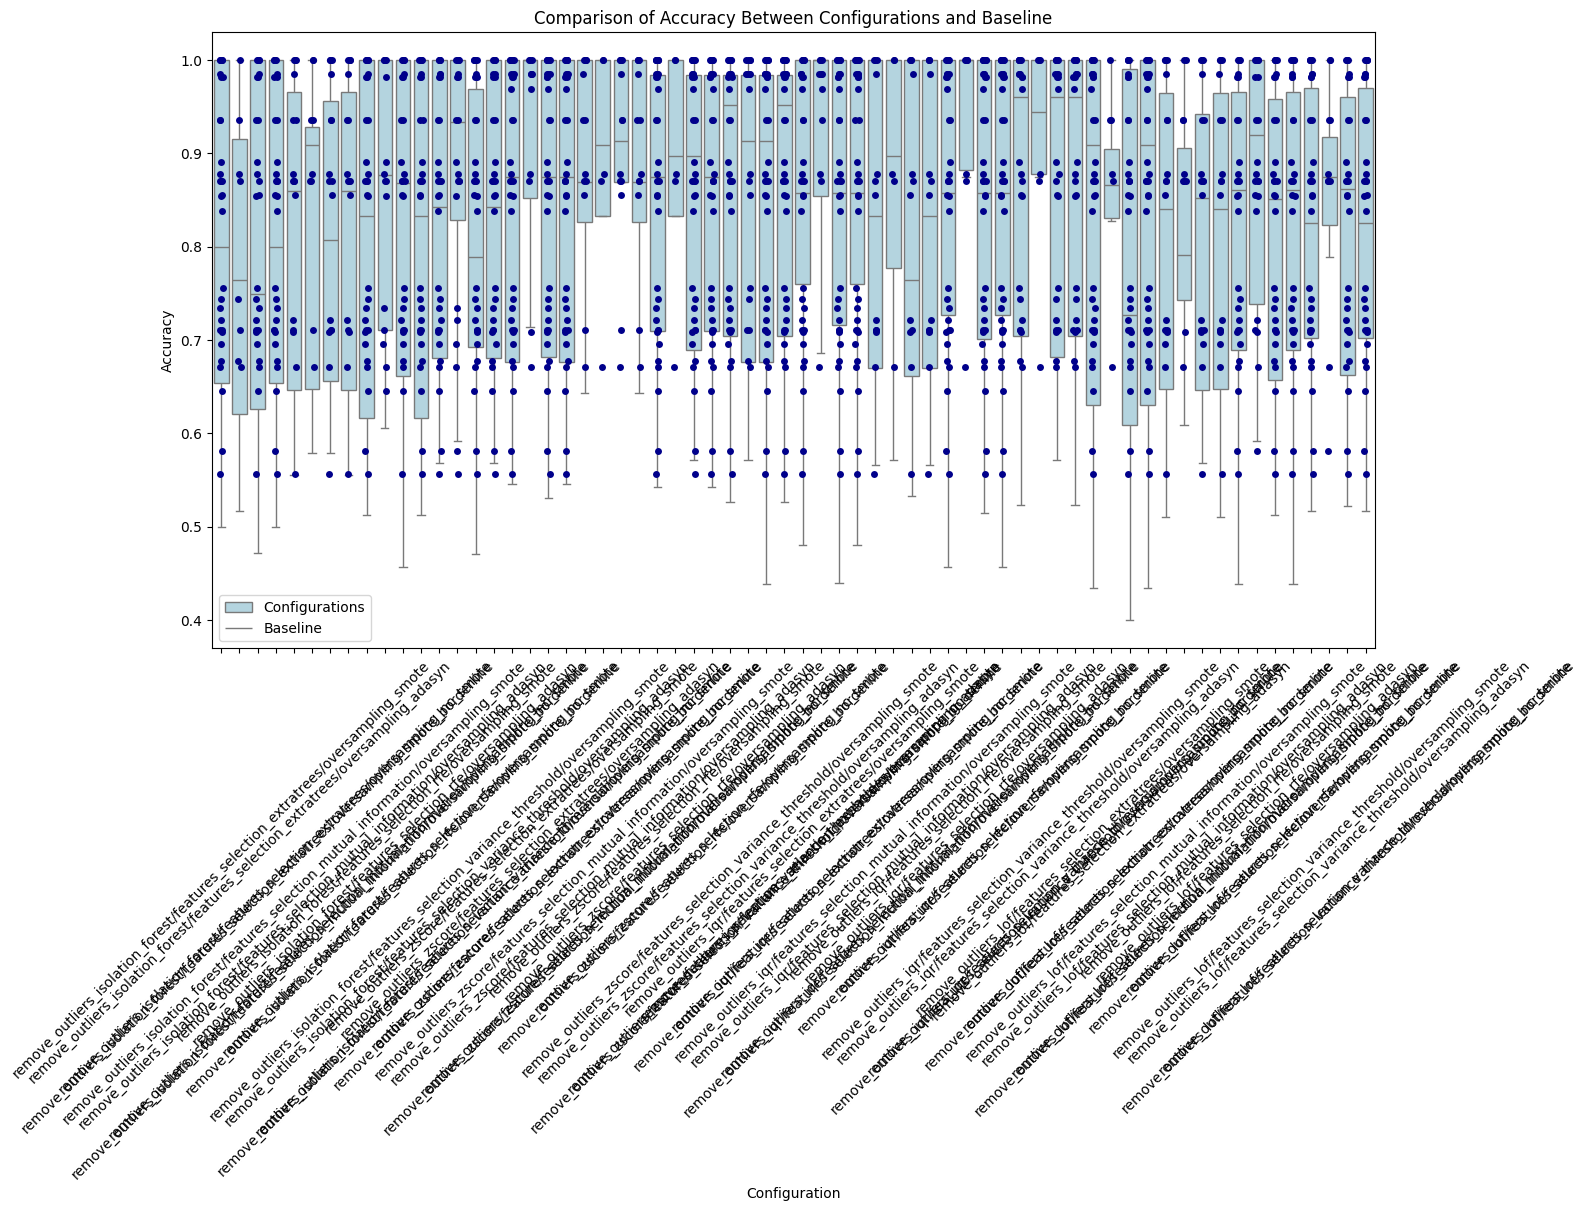

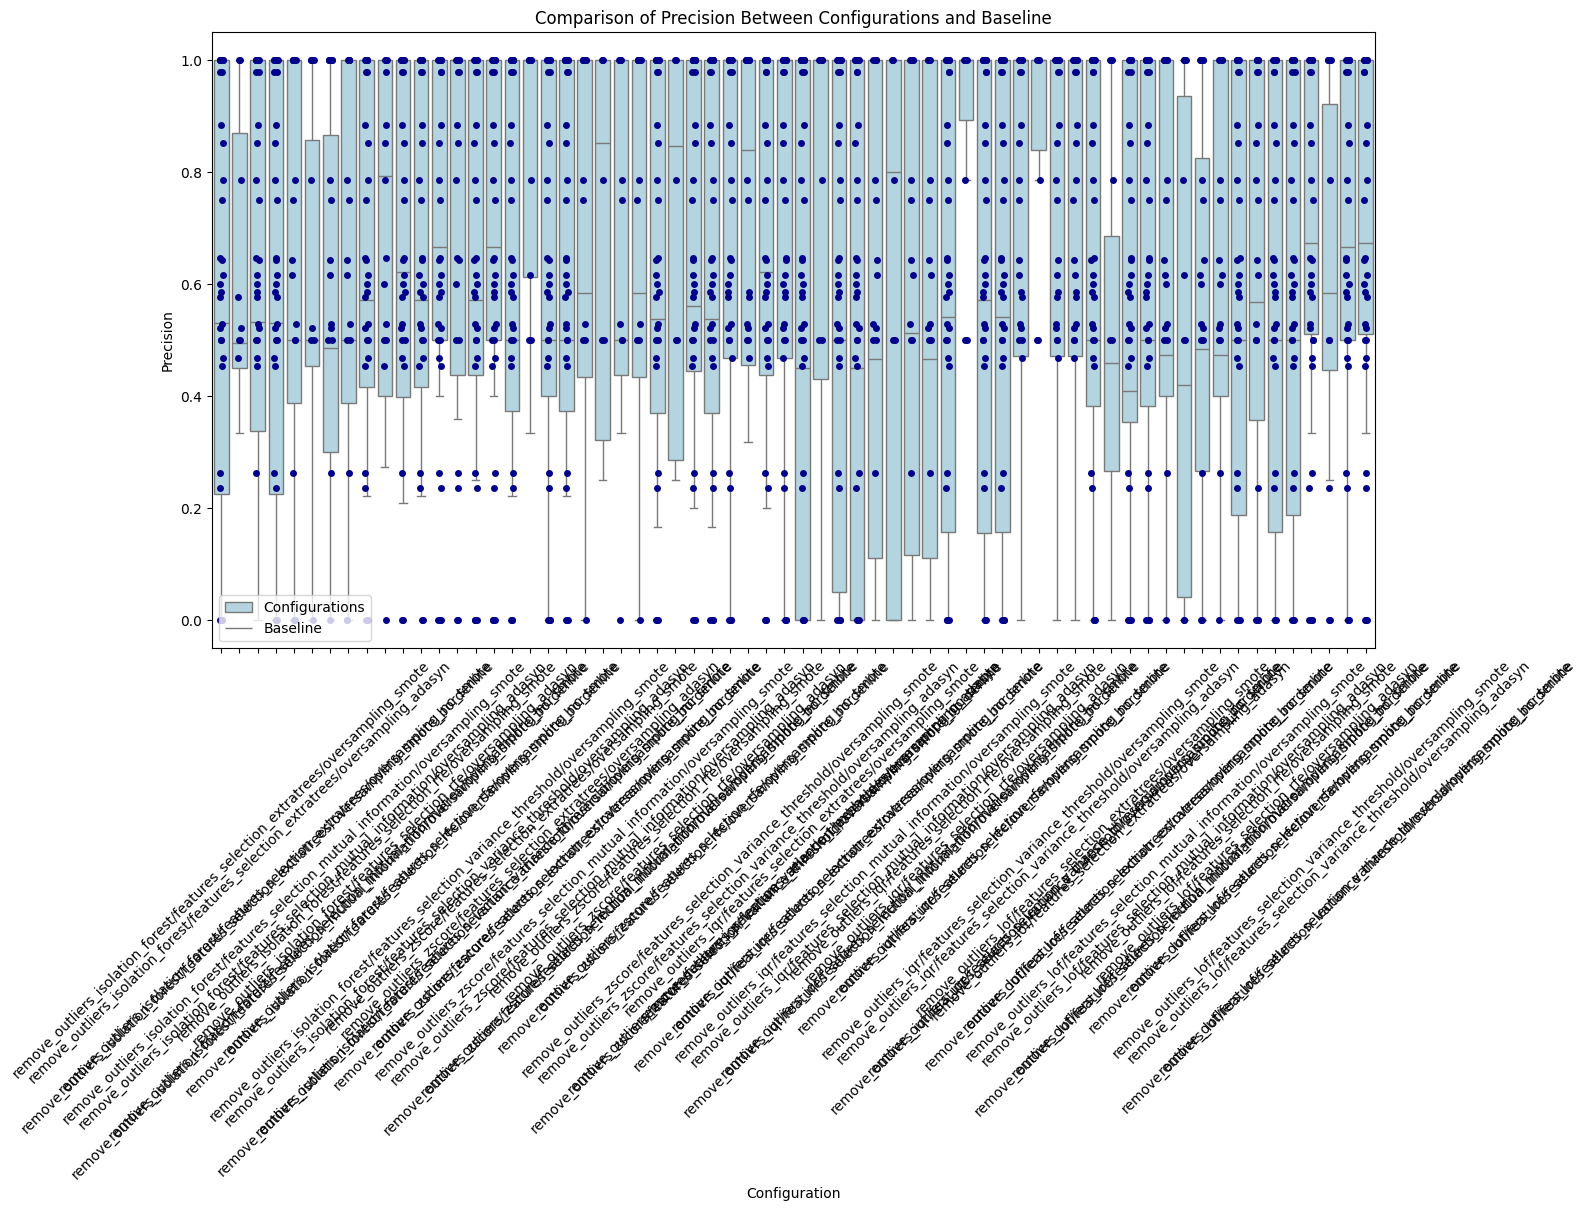

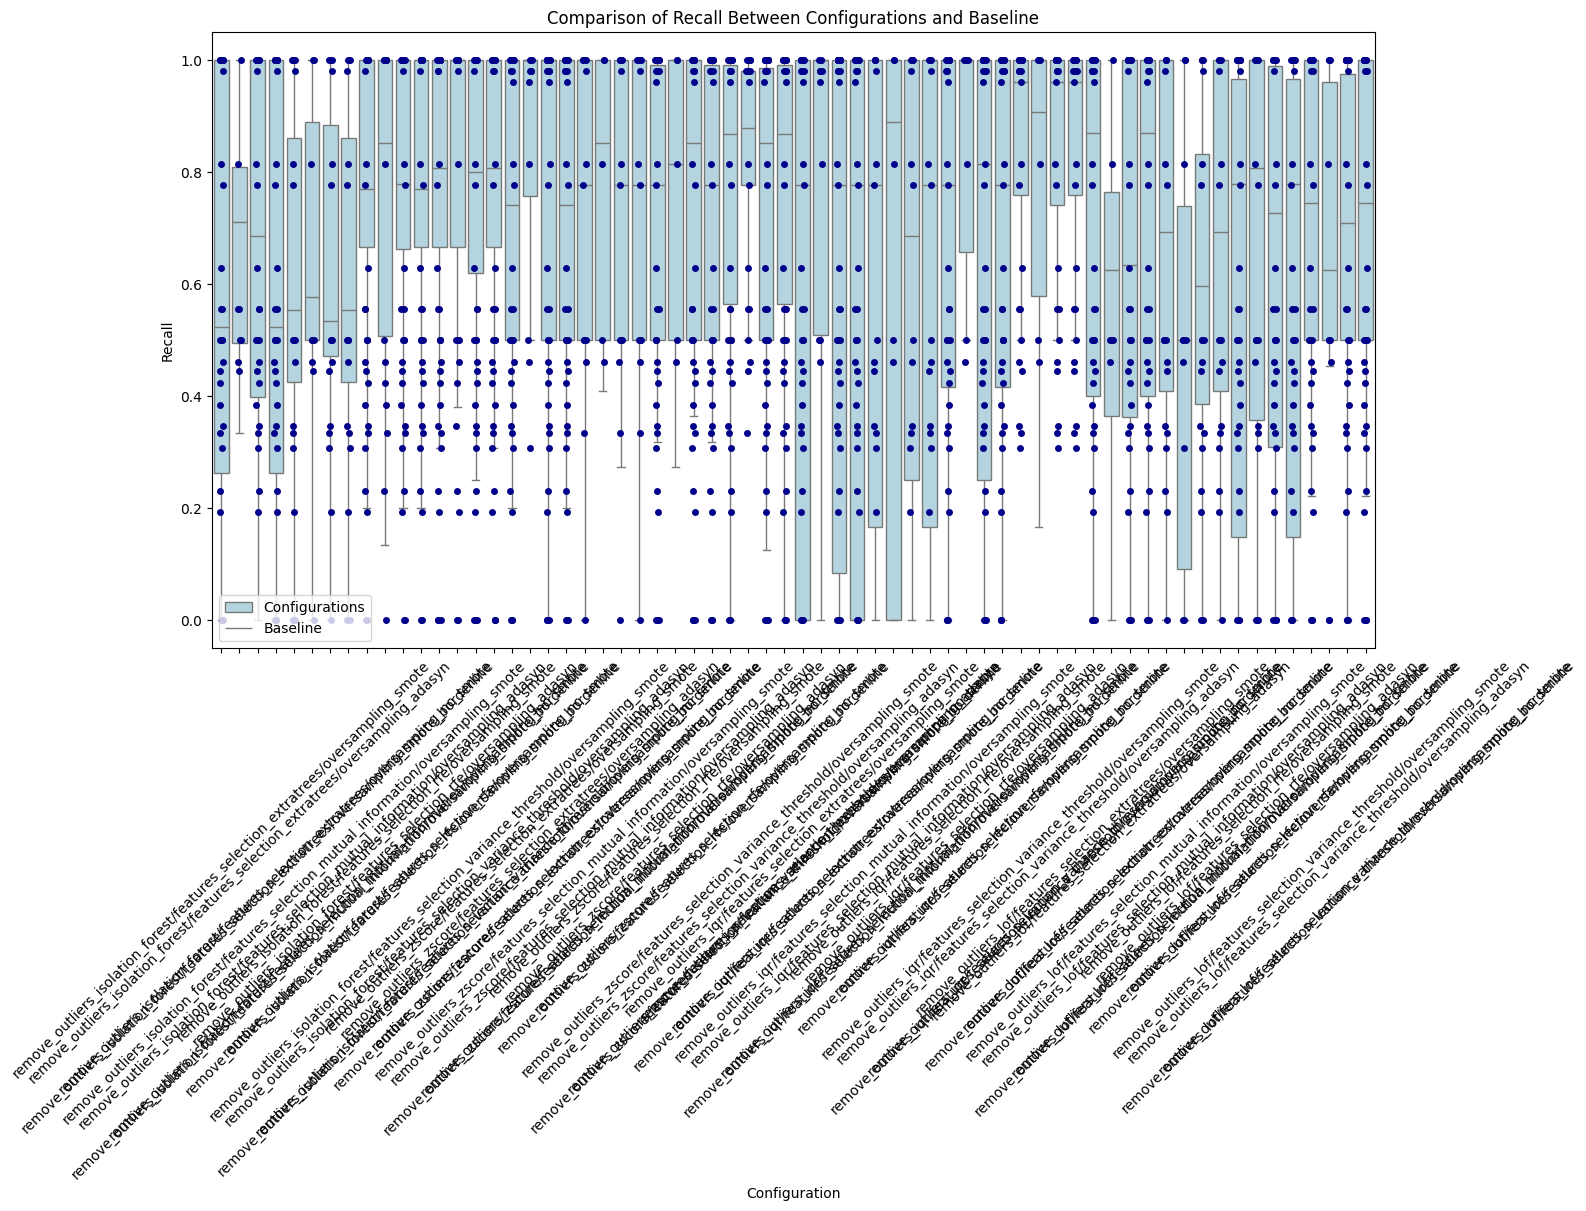

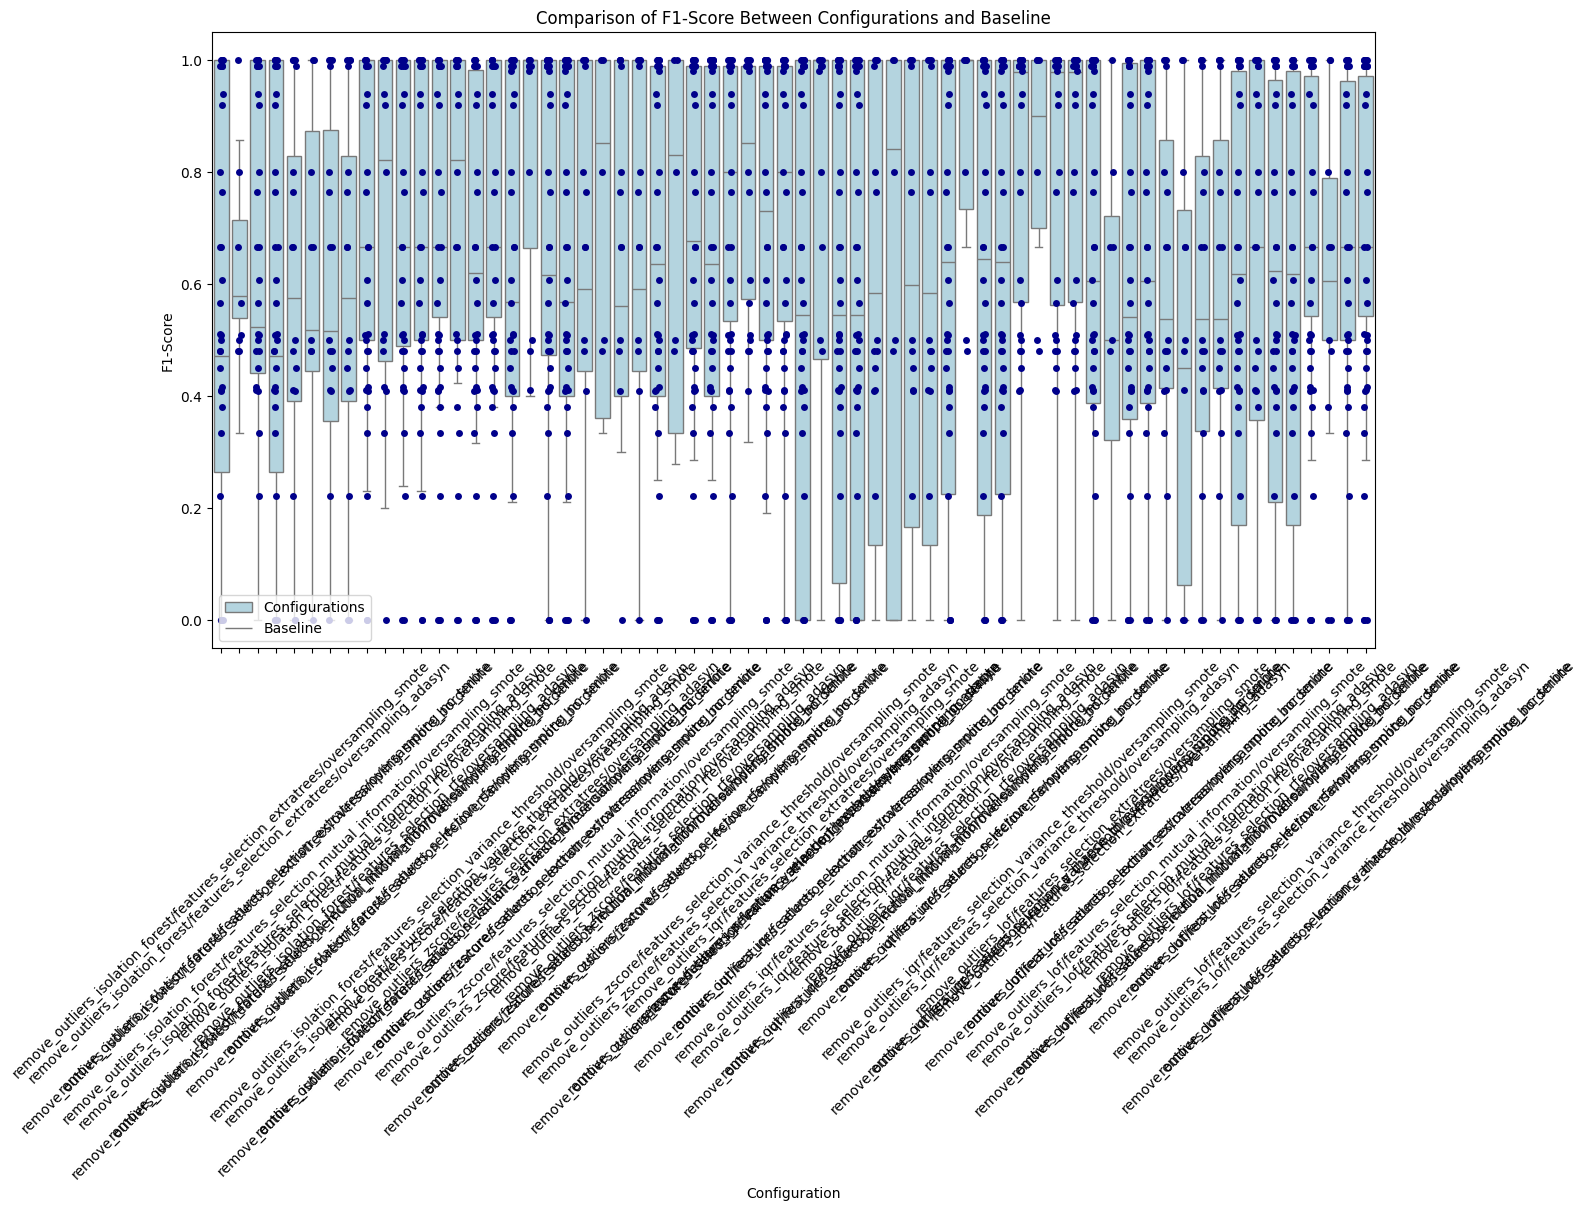

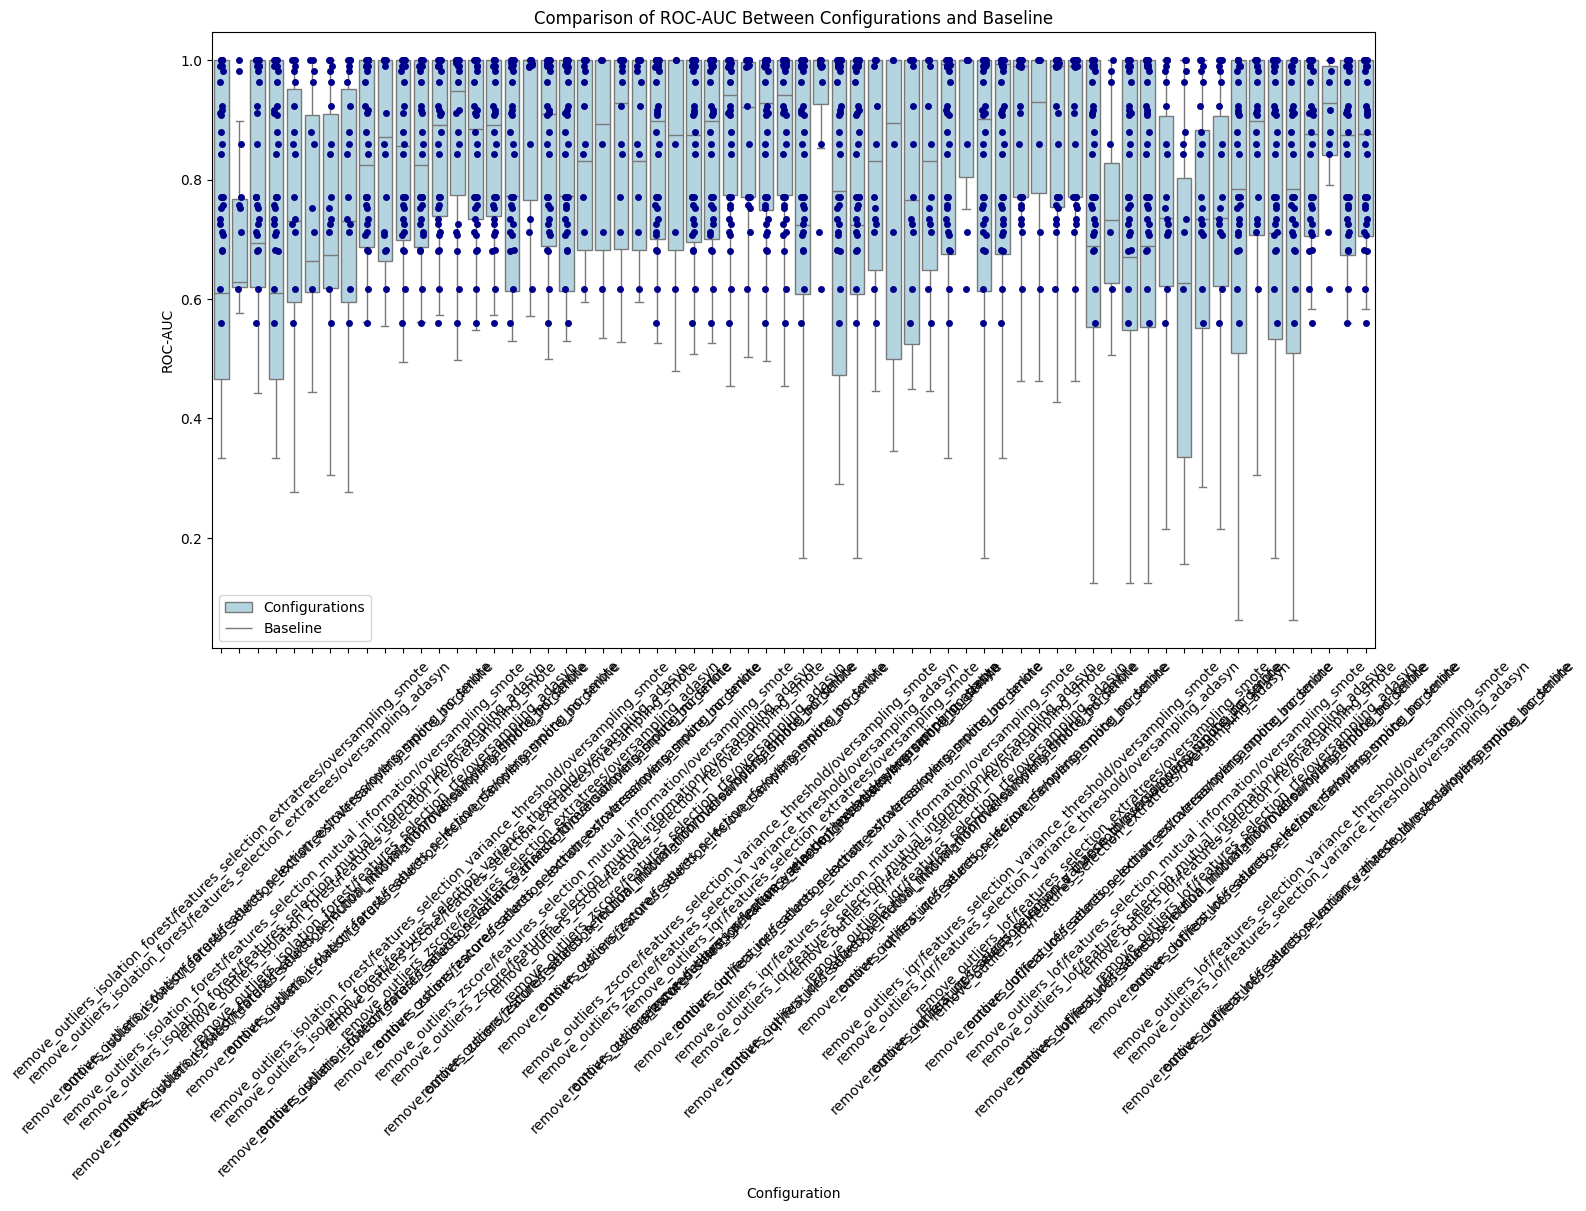

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_results = pd.read_json("results.json")
df_baseline = pd.read_json("results_baseline.json")

merged_df = pd.merge(
    df_results, df_baseline, on=["Dataset", "Model"], suffixes=("_config", "_baseline")
)


def plot_metric_comparison(metric):
    plt.figure(figsize=(15, 8))
    sns.boxplot(
        x="Configuration_config",
        y=f"{metric}_config",
        data=merged_df,
        color="lightblue",
        showfliers=False,
    )
    sns.stripplot(
        x="Configuration_config",
        y=f"{metric}_baseline",
        data=merged_df,
        color="darkblue",
        jitter=True,
    )
    plt.xticks(rotation=45)
    plt.title(f"Comparison of {metric} Between Configurations and Baseline")
    plt.ylabel(metric)
    plt.xlabel("Configuration")
    plt.legend(["Configurations", "Baseline"])
    plt.show()


plot_metric_comparison("Accuracy")
plot_metric_comparison("Precision")
plot_metric_comparison("Recall")
plot_metric_comparison("F1-Score")
plot_metric_comparison("ROC-AUC")

In [64]:
import pandas as pd
import json


def find_top_configs_for_metric(metric, n_top=10):
    metric_of_interest = metric
    avg_metric_per_config = df_results.groupby("Configuration")[
        metric_of_interest
    ].mean()
    top_configs = avg_metric_per_config.sort_values(ascending=False)
    print(top_configs.head(n_top))


with open("results.json", "r") as file:
    results = json.load(file)

df_results = pd.DataFrame(results)

find_top_configs_for_metric("Accuracy")
find_top_configs_for_metric("Precision")
find_top_configs_for_metric("Recall")
find_top_configs_for_metric("F1-Score")
find_top_configs_for_metric("ROC-AUC")

Configuration
remove_outliers_iqr/features_selection_extratrees/oversampling_adasyn                         0.924810
remove_outliers_iqr/features_selection_rfe/oversampling_adasyn                                0.905045
remove_outliers_iqr/features_selection_variance_threshold/oversampling_adasyn                 0.903505
remove_outliers_zscore/features_selection_extratrees/oversampling_adasyn                      0.900335
remove_outliers_zscore/features_selection_mutual_information/oversampling_smote_borderline    0.875523
remove_outliers_lof/features_selection_rfe/oversampling_adasyn                                0.872957
remove_outliers_zscore/features_selection_mutual_information/oversampling_smote               0.871548
remove_outliers_zscore/features_selection_mutual_information/oversampling_nc_smote            0.871548
remove_outliers_isolation_forest/features_selection_variance_threshold/oversampling_adasyn    0.868992
remove_outliers_isolation_forest/features_selection_rfe/ove

In [65]:
import pandas as pd
import json


def load_data(file_path):
    with open(file_path, "r") as file:
        return pd.DataFrame(json.load(file))


def find_top_configs_for_metric_combined(metric, df, n_top=10):
    metric_of_interest = metric
    avg_metric_per_config = df.groupby("Configuration")[metric_of_interest].mean()
    top_configs = avg_metric_per_config.sort_values(ascending=False).head(n_top)
    return top_configs


df_results = load_data("results.json")
df_results_baseline = load_data("results_baseline.json")
df_combined = pd.concat([df_results, df_results_baseline])

excel_file_path = "top_configurations_by_metric.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]:
        top_configs_df = find_top_configs_for_metric_combined(
            metric, df_combined
        ).reset_index()
        top_configs_df.to_excel(writer, sheet_name=metric, index=False)

print(f"Saved Excel file at: {excel_file_path}")

Saved Excel file at: top_configurations_by_metric.xlsx


In [ ]:
# from sklearn.metrics import (
#     roc_auc_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     accuracy_score,
# )

# import json
# import pandas as pd
# from sklearn.metrics import (
#     roc_auc_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     accuracy_score,
# )


# def train_evaluate_models(dataset_splits):
#     models_list = initialize_models(*dataset_splits[0][:2])

#     results = {}
#     metric_data = {
#         "ROC-AUC": {model.__class__.__name__: {} for model in models_list},
#         "Precision": {model.__class__.__name__: {} for model in models_list},
#         "Recall": {model.__class__.__name__: {} for model in models_list},
#         "F1-Score": {model.__class__.__name__: {} for model in models_list},
#         "Accuracy": {model.__class__.__name__: {} for model in models_list},
#     }

#     for model in models_list:
#         model_name = model.__class__.__name__
#         results[model_name] = {}

#         for X_train, y_train, X_test, y_test, dataset_name in dataset_splits:
#             results[model_name][dataset_name] = {}

#             for config in generate_configurations():
#                 config_name = (
#                     f"{config[0].__name__}/{config[1].__name__}/{config[2].__name__}"
#                 )
#                 try:
#                     (
#                         X_train_config,
#                         y_train_config,
#                         X_test_config,
#                         y_test_config,
#                     ) = apply_configuration(X_train, y_train, X_test, y_test, config)

#                     model.fit(X_train_config, y_train_config)
#                     y_test_pred = model.predict(X_test_config)
#                     y_test_pred_proba = model.predict_proba(X_test_config)[:, 1]

#                     # Calculating metrics
#                     test_roc_auc = roc_auc_score(y_test_config, y_test_pred_proba)
#                     precision = precision_score(
#                         y_test_config, y_test_pred, average="weighted"
#                     )
#                     recall = recall_score(
#                         y_test_config, y_test_pred, average="weighted"
#                     )
#                     f1 = f1_score(y_test_config, y_test_pred, average="weighted")
#                     accuracy = accuracy_score(y_test_config, y_test_pred)

#                     # Storing results
#                     results[model_name][dataset_name][config_name] = {
#                         "Train ROC-AUC": roc_auc_score(
#                             y_train_config, model.predict_proba(X_train_config)[:, 1]
#                         ),
#                         "ROC-AUC": test_roc_auc,
#                         "Precision": precision,
#                         "Recall": recall,
#                         "F1-Score": f1,
#                         "Accuracy": accuracy,
#                         # "Overfitting": "Yes"
#                         # if test_roc_auc
#                         # < roc_auc_score(
#                         #     y_train_config, model.predict_proba(X_train_config)[:, 1]
#                         # )
#                         # else "No",
#                     }
#                 except:
#                     continue

#                 # # Store metrics for statistical analysis
#                 # for metric in metric_data:
#                 #     metric_data[metric][model_name].setdefault(dataset_name, []).append(
#                 #         locals()[metric.lower()]
#                 #     )

#     # Convert metric data to DataFrames
#     metric_dfs = {metric: pd.DataFrame(data) for metric, data in metric_data.items()}
#     return results, metric_dfs

# evaluation_results, metric_dfs = train_evaluate_models(dataset_splits_stratified)

# # Save the detailed results
# with open("results/final_results.json", "w") as file:
#     json.dump(evaluation_results, file, indent=4)

# # Save metric data for statistical tests
# for metric, df in metric_dfs.items():
#     df.to_csv(f"results/{metric.lower()}_data.csv")

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import json

# with open(results_output_path, "r") as file:
#     results_baseline = json.load(file)


# def plot_top_configurations(results, model_name, dataset_name, top_n=5):
#     # Extracting results for the specified model and dataset
#     model_results = results.get(model_name, {})
#     dataset_results = model_results.get(dataset_name, {})

#     # Convert to DataFrame for easy sorting and manipulation
#     df = pd.DataFrame(dataset_results).T
#     df["Configuration"] = df.index
#     df.sort_values(by="Test ROC-AUC", ascending=False, inplace=True)

#     # Select top N configurations
#     top_configs = df.head(top_n)

#     # Plotting
#     plt.figure(figsize=(12, 6))
#     plt.barh(top_configs["Configuration"], top_configs["Test ROC-AUC"], color="skyblue")
#     plt.xlabel("Test ROC-AUC")
#     plt.title(f"Top {top_n} Configurations for {model_name} on {dataset_name}")
#     plt.gca().invert_yaxis()  # To display the highest score at the top
#     plt.show()


# # Extract model and dataset names for plotting
# model_names = list(results_baseline.keys())
# dataset_names = list(results_baseline[model_names[0]].keys())

# # Plotting top configurations for the first few model-dataset combinations
# for model_name in model_names:
#     for dataset_name in dataset_names:
#         plot_top_configurations(results_baseline, model_name, dataset_name)

In [ ]:
# from scipy.stats import friedmanchisquare
# import scikit_posthocs as sp
# import pandas as pd

# # Load the test_roc_auc_df DataFrame
# # test_roc_auc_df = pd.read_csv('path/to/test_roc_auc_data.csv')

# # Friedman Test
# friedman_stat, friedman_p = friedmanchisquare(*[test_roc_auc_df[model].values for model in test_roc_auc_df.columns])
# print("Friedman Test statistic:", friedman_stat)
# print("Friedman Test p-value:", friedman_p)

# # # Nemenyi Post-hoc Test
# # if friedman_p < 0.05:
# #     # The data needs to be in a long-format for posthoc_nemenyi_friedman
# #     long_format_data = test_roc_auc_df.melt(var_name='Model', value_name='Test ROC-AUC')
# #     nemenyi = sp.posthoc_nemenyi_friedman(long_format_data, val_col='Test ROC-AUC', group_col='Model')
# #     print("Nemenyi Test Results:\n", nemenyi)
# # else:
# #     print("No significant differences found by Friedman Test.")

# long_format_data = test_roc_auc_df.melt(var_name='Model', value_name='Test ROC-AUC')

# # Preparing data for Nemenyi test
# groups = long_format_data['Model'].values
# scores = long_format_data['Test ROC-AUC'].values

# # Nemenyi Post-hoc Test
# nemenyi = sp.posthoc_nemenyi_friedman(groups, scores)
# print("Nemenyi Test Results:\n", nemenyi)


TO-DO

- hacer nemenyi por metricas
- hacer nemenyi por otras metricas (f1)
- ranking por conteo de tecnicas
- ranking por conteo de tecnicas, comparando f1 y roc
- meter el otro dataset
- en el nemenyi, quedarme con los mejores